# Проект по портфельному менеджменту   

## Часть 1. Нахождение суммы для покрытия обязательных расходов на 20 лет с помощью метода Монте-Карло. 

стоит упомянуть, что мы делаем 2 предположения: 
1. мы не моделируем лестницу облигаций (модель рассматривает просто ставку доходности)
2. купоны реинвестируются

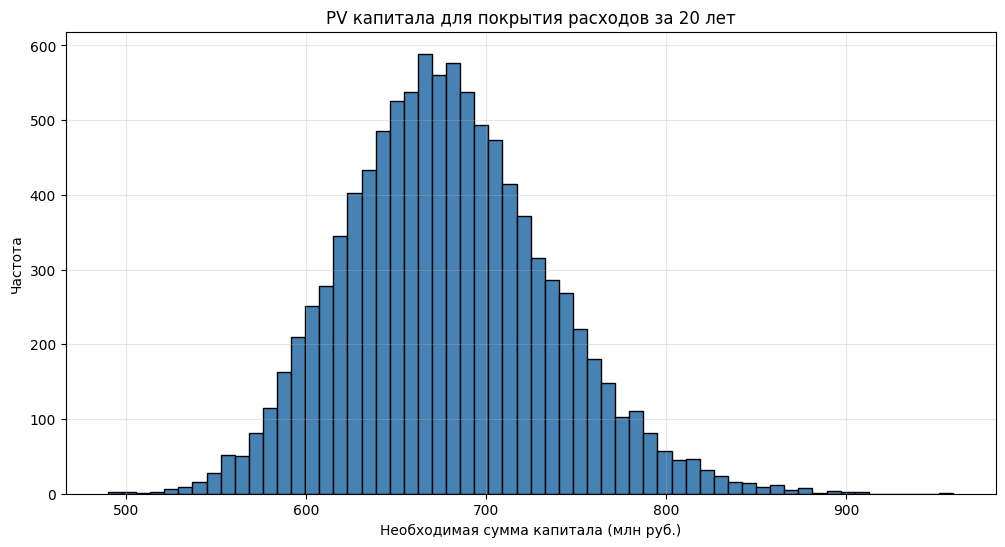

Капитал, который покроет траты с вероятностью 90%: 752 млн руб.
Остаток капитала для второго слоя: 148 млн руб.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)


# 1. входные данные
n_sims = 10000
years = 20
months = years * 12

monthly_expense = 4_000_000 



# 2. параметры симулирования инфляции 
annual_infl_mean = 0.04         # 4% в год
annual_infl_vol  = 0.02         # 2% в год

infl_monthly_mean = (1 + annual_infl_mean)**(1/12) - 1     # ≈ 0.327% в месяц
infl_monthly_vol  = annual_infl_vol / np.sqrt(12)          # ≈ 0.0043 (0.43%)



# 3. параметры симулирования номинальной доходности ОФЗ
annual_nominal_mean = 0.08       
annual_nominal_vol  = 0.03       

nominal_monthly_mean = (1 + annual_nominal_mean)**(1/12) - 1     # ≈ 0.64% в месяц
nominal_monthly_vol  = annual_nominal_vol / np.sqrt(12)          # ≈ 0.87% в месяц


# 4. Симуляция NPV обязательств

pv_results = []

for _ in range(n_sims):

    # случайная месячная инфляция
    infl = np.random.normal(infl_monthly_mean, infl_monthly_vol, months)

    # будущие расходы
    expenses = monthly_expense * np.cumprod(1 + infl) # cumprod - кумулятивное произведение 

    # номинальная доходность офз 
    bond_r = np.random.normal(nominal_monthly_mean, nominal_monthly_vol, months)

    # дисконт
    discount = np.cumprod(1 + bond_r)

    pv = np.sum(expenses / discount)
    pv_results.append(pv)

pv_results = np.array(pv_results)


# 5. график PV в млн рублей 
plt.figure(figsize=(12,6))
plt.hist(pv_results / 1e6, bins=60, color='steelblue', edgecolor='black')
plt.title('PV капитала для покрытия расходов за 20 лет')
plt.xlabel('Необходимая сумма капитала (млн руб.)')
plt.ylabel('Частота')
plt.grid(alpha=0.3)
plt.show()

# расчет 90-го процентиля 
pv_90 = np.percentile(pv_results, 90)
print(f"Капитал, который покроет траты с вероятностью 90%: {pv_90/1_000_000:.0f} млн руб.")
print(f'Остаток капитала для второго слоя: {900 - pv_90/1_000_000:.0f} млн руб.')


## Часть 2. Нахождение весов активов для опционной стратегии. 

## Модель HPR 

### План алгоритма HRP (Hierarchical Risk Parity)

#### Шаг 0. Входные данные
- Есть N активов (акции).
- Для каждого актива есть временной ряд цен закрытия.
- Цель: получить вектор весов w для портфеля HRP.

---

#### Шаг 1. Посчитать доходности и ковариацию
1. По ценам считаем доходности за каждый день.
2. Из матрицы доходностей считаем:
   - ковариационную матрицу Σ,  
   - корреляционную матрицу Corr.

---

#### Шаг 2. Превратить корреляции в “расстояния”
1. Строим матрицу расстояний D из корреляций, например:

   $$d_{ij} = \sqrt{\frac{1 - Corr_{ij}}{2}}$$

2. Это даёт значения от 0 до 1:
   - 0 — полностью одинаковые активы,
   - 1 — максимально несхожие.

Матрица расстояний нужна для последующей кластеризации.

---

#### Шаг 3. Иерархическая кластеризация активов
1. На основе D применяем иерархическую кластеризацию:
   - метод single / average / ward
2. Получаем дерево кластеров:
   - какие активы объединяются в группы,
   - в каком порядке,
   - на каких расстояниях.

---

#### Шаг 4. Квазидиагонализация 
1. Берём дерево и раскручиваем его в линейный порядок:
   - обходим дерево и получаем список индексов активов так, чтобы похожие (коррелированные) активы оказались рядом.
2. В этом порядке переставляем строки и столбцы корреляционной/ковариационной матрицы.

**Результат:** матрица становится почти блочно-диагональной — видны кластеры.

---

#### Шаг 5. Рекурсивная бисекция (распределение риска по иерархии)

Теперь главное — как из иерархии получить веса.

1. Начинаем с одного кластера, содержащего все активы (в порядке из предыдущего шага).
2. Повторяем:
   1. Делим текущий кластер пополам (левая и правая часть списка активов).
   2. Для каждой половины считаем кластерный риск:
      - берём подматрицу ковариации для активов внутри кластера,
      - внутри кластера строим портфель по inverse-variance (IVP),
      - считаем дисперсию кластера:

        $$Var_{\text{cluster}} = w^\top \Sigma w$$

   3. Распределяем общий вес между двумя кластерами обратно пропорционально их риску:
      - более рискованный кластер → меньший вес,
      - менее рискованный → больший вес.
   4. Вес всех активов внутри каждого кластера умножается на соответствующий коэффициент.
3. Спускаемся вниз по дереву:
   - на каждом уровне делим кластеры ещё пополам,
   - пересчитываем веса между ними.
4. Останавливаемся, когда кластеры состоят из одного актива.

**Результат:** веса HRP для каждого актива.

---

#### Шаг 6. Нормализация и проверка
1. Нормируем веса, чтобы их сумма была 1 (или равнялась нужному капиталу).
2. Проверяем:
   - нет ли отрицательных весов,
   - нет ли экстремальных концентраций,
   - сравниваем риск/доходность с равновесовым портфелем или классическим Марковицем.

---
#### Дополнительно для нашего проекта 
#### Шаг 7. Применение к опционам
Полученные веса HRP используем как доли в опционной части (сколько бюджета выделять под call-spread на каждую акцию).


**Код алгоритма взят из книги, где этот алгоритм описан (Maroc Lopez De Prado 'Advances in financial Mashine Learning')**

### Реализация алгоритма 

In [43]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
import glob

In [ ]:
# Папка, где лежат CSV с ценами
path = "all_stocks_data/*.csv"

dfs = []
for file in glob.glob(path):
    ticker = file.split("/")[-1].split(".")[0]   
    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.rename(columns={df.columns[1]: ticker})  # второй столбец — цена
    dfs.append(df)

# объединяем по дате
prices = dfs[0]
for df in dfs[1:]:
    prices = pd.merge(prices, df, on="Date", how="inner")

prices = prices.set_index("Date").sort_index()
returns = prices.pct_change().dropna() # сделали доходности из цен 
returns.columns = returns.columns.str.split('_').str[0]
returns.head()

,PEP,RIO,NUE,COST,XOM,WMT,PG,BHP,KO,NESN,JNJ,NSRGY,MSFT,MCD,NEE,SHEL
Date,,,,,,,,,,,,,,,,
2020-12-07,0.001048,0.002706,0.003899,0.030783,0.050864,-0.012826,-0.006983,0.023153,-0.001517,0.016364,0.017834,0.014155,-0.005132,-0.008281,0.017651,-0.010986
2020-12-14,0.013520,0.033594,-0.047846,-0.021594,-0.024429,-0.003514,0.018534,0.018599,0.007310,0.016696,0.010199,0.026413,0.024993,0.035233,0.009620,-0.013489
2020-12-21,-0.012727,-0.008746,-0.027628,-0.006594,-0.026445,-0.016787,-0.009493,-0.008673,-0.005582,-0.010362,-0.013203,-0.022980,0.019031,-0.017156,0.006308,-0.039410
2020-12-28,0.022336,-0.009481,0.014302,0.033463,-0.009134,0.004530,0.010311,0.002916,0.026198,0.029830,0.032203,0.037703,-0.001481,0.015091,0.028941,-0.019258
2021-01-04,-0.027782,0.152486,0.061460,-0.018154,0.102863,0.017204,-0.002516,0.124273,-0.068563,-0.027815,0.016901,-0.025128,-0.012589,0.006012,0.051588,0.145134


In [48]:
def get_ivp(cov: pd.DataFrame) -> np.ndarray:
    """
    Inverse-Variance Portfolio: веса ~ 1/variance_i
    """
    ivp = 1.0 / np.diag(cov.values)
    ivp /= ivp.sum()
    return ivp


def get_cluster_var(cov: pd.DataFrame, cluster_items) -> float:
    """
    Дисперсия кластера: w^T Σ w, где w = IVP внутри кластера
    """
    cov_ = cov.loc[cluster_items, cluster_items]
    w_ = get_ivp(cov_).reshape(-1, 1)
    cvar = float(w_.T @ cov_.values @ w_)
    return cvar


def get_quasi_diag(link: np.ndarray):
    """
    Квазидиагональная сортировка по дереву.
    Возвращает порядок индексов исходных активов.
    """
    link = link.astype(int)
    sort_ix = pd.Series([link[-1, 0], link[-1, 1]])
    num_items = link[-1, 3]  # число исходных объектов

    while sort_ix.max() >= num_items:
        # вставляем «пустые» места между элементами
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)

        # элементы, которые являются кластерами (индекс >= num_items)
        df0 = sort_ix[sort_ix >= num_items]
        i = df0.index
        j = df0.values - num_items

        # первый потомок кластера
        sort_ix[i] = link[j, 0]

        # второй потомок кластера
        df1 = pd.Series(link[j, 1], index=i + 1)
        sort_ix = pd.concat([sort_ix, df1]).sort_index()
        sort_ix.index = range(sort_ix.shape[0])

    return sort_ix.tolist()


def get_rec_bipart(cov: pd.DataFrame, sorted_idx) -> pd.Series:
    """
    Рекурсивная бисекция: основа HRP.
    На входе ковариация и порядок активов (после квазидиагонализации),
    на выходе веса HRP.
    """
    weights = pd.Series(1.0, index=sorted_idx)
    clusters = [sorted_idx]

    while len(clusters) > 0:
        # делим каждый кластер пополам
        new_clusters = []
        for cluster in clusters:
            if len(cluster) <= 1:
                continue
            split = len(cluster) // 2
            new_clusters.append(cluster[:split])
            new_clusters.append(cluster[split:])
        clusters = new_clusters

        # для каждой пары кластеров распределяем веса
        for i in range(0, len(clusters), 2):
            if i + 1 >= len(clusters):
                continue
            c0 = clusters[i]
            c1 = clusters[i + 1]
            var0 = get_cluster_var(cov, c0)
            var1 = get_cluster_var(cov, c1)
            alpha = 1.0 - var0 / (var0 + var1)
            weights[c0] *= alpha
            weights[c1] *= 1.0 - alpha

    return weights / weights.sum()

In [49]:
def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist

In [51]:
def correl_dist(corr: pd.DataFrame) -> pd.DataFrame:
    """
    Матрица расстояний из корреляций:
    d_ij = sqrt((1 - corr_ij)/2)
    """
    dist = np.sqrt(0.5 * (1.0 - corr))
    return dist


def plot_corr_matrix(corr: pd.DataFrame, title: str = ""):
    plt.figure(figsize=(5, 4))
    plt.pcolor(corr.values)
    plt.colorbar()
    plt.xticks(np.arange(0.5, corr.shape[1] + 0.5), corr.columns, rotation=90)
    plt.yticks(np.arange(0.5, corr.shape[0] + 0.5), corr.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [55]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

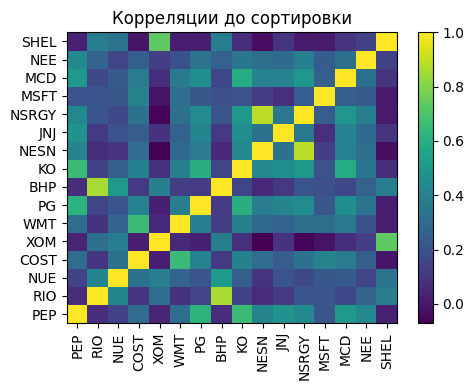

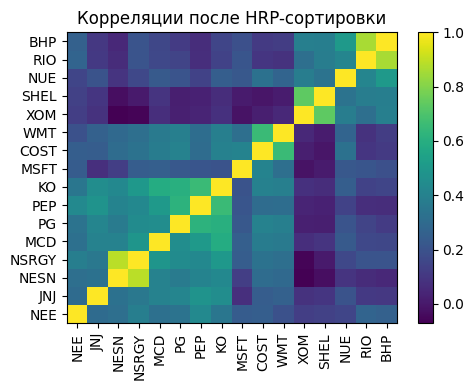

NEE      0.042090
JNJ      0.124018
NESN     0.071230
NSRGY    0.054582
MCD      0.076961
PG       0.081127
PEP      0.070960
KO       0.077490
MSFT     0.057786
COST     0.063008
WMT      0.099416
XOM      0.054714
SHEL     0.056303
NUE      0.020899
RIO      0.026866
BHP      0.022549
dtype: float64

In [59]:
# ковариация и корреляция
cov = returns.cov()
corr = returns.corr()

# смотрим исходную корреляцию
plot_corr_matrix(corr, title="Корреляции до сортировки")

# строим дерево 
dist = correl_dist(corr)
# linkage ждёт condensed distance matrix, преобразуем:
dist_condensed = squareform(dist.values, checks=False)
link = sch.linkage(dist_condensed, method="single")

# квазидиагонализация
sort_idx = get_quasi_diag(link)
sorted_labels = corr.index[sort_idx].tolist()
corr_sorted = corr.loc[sorted_labels, sorted_labels]

plot_corr_matrix(corr_sorted, title="Корреляции после HRP-сортировки")

# вычисляем веса HRP
hrp_weights = get_rec_bipart(cov, sorted_labels)
hrp_weights

## Часть 3. Расчет доли капитала второго слоя, которая нужна для полной защиты. 

Идея состоит в следующем: 
- мы хотим получить полную защиту капитала
- по опционам максимальный убыток равен сумме, вложенной в опционы 
- пусть остаток капитала (после вклада в ОФЗ для покрытия расходов) равен L 
- пусть сумма, вложенная опционы, ранвна X
- тогда сумма на ОФЗ для покрытия потенциальных убытков от опционов равна L-X
- для полной защиты должно выполняться уравнение (L-X)*k = L, где k = (1+i1)(1+i2)... (кф роста суммы по облигациям)
- откуда  капитал на опционы X = L*(1-1/k)
- для полученния k используем метод Монте-Карло. Возьмем такое k, что левее 10% (то есть с вероятностью 90% мы защитим макимальные убытки от опционов)

10-й перцентиль мультипликатора k: 3.898


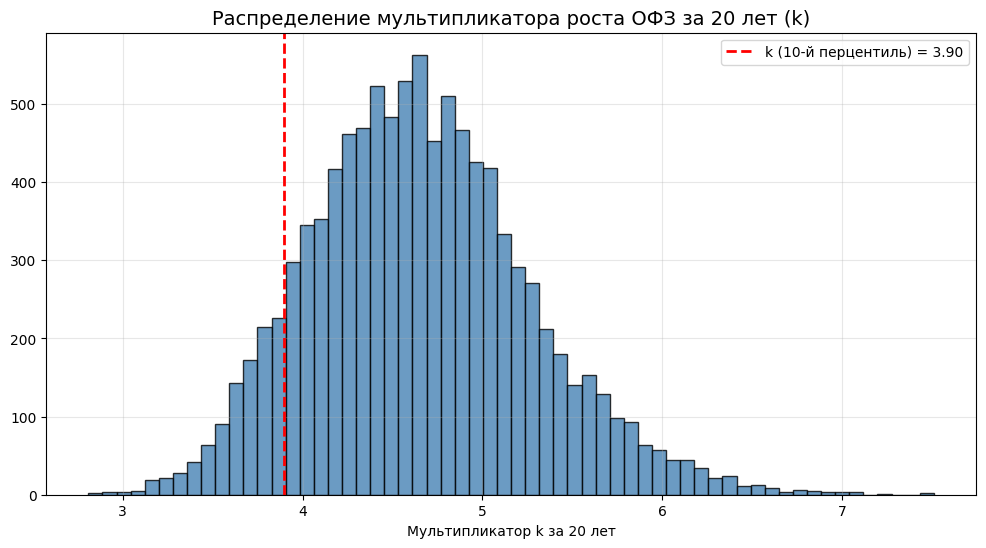

In [61]:
np.random.seed(42)

n_sims = 10000          
years = 20
months = years * 12

# параметры номинальной доходности ОФЗ 
annual_nominal_mean = 0.08       # 8% годовых
annual_nominal_vol  = 0.03       # 3% годовая волатильность

# перевод в месячный формат
nominal_monthly_mean = (1 + annual_nominal_mean)**(1/12) - 1
nominal_monthly_vol  = annual_nominal_vol / np.sqrt(12)


# Монте-Карло для мультипликатора k

multipliers = []

for _ in range(n_sims):
    # симулируем помесячные доходности ОФЗ
    r_monthly = np.random.normal(nominal_monthly_mean, nominal_monthly_vol, months)
    # мультипликатор роста за 20 лет
    K = np.prod(1 + r_monthly)
    multipliers.append(K)

multipliers = np.array(multipliers)

# 10-й перцентиль 
k_10 = np.percentile(multipliers, 10)
print(f"10-й перцентиль мультипликатора k: {k_10:.3f}")


# график распределения k


plt.figure(figsize=(12, 6))
plt.hist(multipliers, bins=60, color="steelblue", edgecolor="black", alpha=0.8)
plt.axvline(k_10, color="red", linestyle="--", linewidth=2, label=f"k (10-й перцентиль) = {k_10:.2f}")
plt.title("Распределение мультипликатора роста ОФЗ за 20 лет (k)", fontsize=14)
plt.xlabel("Мультипликатор k за 20 лет")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

In [64]:
# доля на опционы (1-1/k)

print(f'доля на оционы: {round(1-1/k_10, 3)}')

доля на оционы: 0.743


теперь можно посчитать
1. Сумму, которая пойдет на облигации (для покрытия максимального учбытка)
2. Сумму, которая пойдет на опционы 
3. Суммы, которые нужно выделить на каждый опцион

## Часть 4. Ожидаемая доходность порфтеля 

In [ ]:
import os 

folder_path = "all_stocks_data/"
files = glob.glob(os.path.join(folder_path, "*.csv"))

stocks = {}

for file in files:
    ticker = os.path.basename(file).replace("_weekly_close.csv", "")
    df = pd.read_csv(file)
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()
    stocks[ticker] = df


prices = pd.concat(stocks.values(), axis=1)
prices.columns = list(stocks.keys())
prices = prices.dropna()      

log_rets = np.log(prices / prices.shift(1)).dropna()
weeks_per_year = 52

# годовые параметры нормального распределения лог-доходности
mu_1y = log_rets.mean() * weeks_per_year
sigma_1y = log_rets.std() * np.sqrt(weeks_per_year)

params = pd.DataFrame({"mu_1y": mu_1y, "sigma_1y": sigma_1y})
print("Годовые параметры по акциям:")
display(params)


# Монте-Карло 

n_sims  = 10000   # число траекторий
n_years = 20

# для итоговых статистик
stats_rows = []

# словарь: тикер -> массив цен (n_sims, n_years+1)
simulated_paths = {}

for ticker in prices.columns:
    S0   = prices[ticker].iloc[-1]               # текущая цена
    mu   = params.loc[ticker, "mu_1y"]
    sigma = params.loc[ticker, "sigma_1y"]
    
    # симулируем годовые лог-доходности (n_sims x n_years)
    R = np.random.normal(mu, sigma, size=(n_sims, n_years))
    
    #  накопленные лог-доходности за 
    cum_R = np.cumsum(R, axis=1)   # форма (n_sims, n_years)
    
    # цены в конце каждого года
    # хотим матрицу (n_sims, n_years+1) с S0 в нулевом столбце
    ST = S0 * np.exp(cum_R)        # (n_sims, n_years)
    ST_full = np.concatenate([np.full((n_sims, 1), S0), ST], axis=1)
    
    simulated_paths[ticker] = ST_full
    
    # считаем статистики по годам
    for year in range(1, n_years + 1):
        prices_year = ST_full[:, year]  # все симуляции на конец данного года
        
        stats_rows.append({
            "Ticker": ticker,
            "Year": year,
            "Mean_price": np.mean(prices_year),
            "Median_price": np.median(prices_year),
            "P10_price": np.percentile(prices_year, 10),
            "P90_price": np.percentile(prices_year, 90)
        })

# оформляем всё в таблицу
stats_df = pd.DataFrame(stats_rows).set_index(["Ticker", "Year"])
display(stats_df.head(30))

Годовые параметры по акциям:


,mu_1y,sigma_1y
PEP,0.034239,0.168825
RIO,0.076514,0.300971
NUE,0.224291,0.407422
COST,0.195167,0.232487
XOM,0.244923,0.286756
WMT,0.173988,0.217284
PG,0.039998,0.169306
BHP,0.060182,0.330710
KO,0.091426,0.161512
NESN.SW,-0.014774,0.171766


Mean_price  Median_price   P10_price   P90_price
Ticker Year                                                  
PEP    1     156.218159    153.867541  123.976373  191.020162
       2     163.992120    159.371003  117.932946  215.910913
       3     171.946758    164.434483  113.042784  239.686449
       4     180.249985    171.001211  109.812377  263.275604
       5     188.976696    176.654114  109.389452  283.564491
       6     198.174756    182.729837  107.751956  306.418079
       7     208.124603    189.623870  107.311749  329.818273
       8     219.042639    197.656108  107.323365  358.361719
       9     229.812975    205.471272  106.609257  384.072443
       10    240.950414    211.154100  105.980450  409.188237
       11    253.494403    219.741956  105.881110  440.424814
       12    266.144415    225.331346  106.552493  474.845697
       13    279.618278    233.156715  107.086101  505.093571
       14    292.958064    240.919972  107.989027  534.180004
       15    307.135950    248.583713  108.142737  576.659872
       16    322.484887    258.784715  108.494369  613.569253
       17    338.771108    268.859075  110.110422  651.917300
       18    355.102403    278.187548  110.398835  694.524267
       19    372.856712    286.594899  111.701835  736.404968
       20    393.603121    294.969278  114.461481  780.360342
RIO    1      81.572948     77.738344   53.041825  114.945129
       2      92.937981     84.461759   48.699898  146.170998
       3     104.660853     90.883407   46.452580  179.864048
       4     118.960751     98.932503   44.704051  214.371778
       5     134.424375    106.814511   44.520418  252.894472
       6     151.659735    114.795734   43.602586  296.471458
       7     169.694097    124.653244   43.529230  340.636454
       8     190.015878    131.592443   43.724384  394.143573
       9     213.931607    144.609866   44.256712  453.682219
       10    241.531209    155.788135   45.243220  513.235485

In [93]:
# сохраним датафрейм 

stats_df.to_csv("prices_stat.csv", index=False)